<a href="https://colab.research.google.com/github/aTegart/abc-music-gen/blob/main/D3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting set up:

You will be connecting to your personal google drive, so make sure you have '/content/drive/My Drive/CS 486 Music Generation/' present (without the ending space, so Celine I changed your folder name). This code now reads from all song folders. Please make sure you are on the latest version of the songs, because on Nov 11 changes were made to filetypes and to remove accented characters. When uploading files to your personal google drive, make sure to have "convert uploads" unchecked in your settings.

Remember you need to authenticate when you remount, and copy the auth code from the link.





In [1]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Check position


In [3]:
!pwd
!cd './drive/My Drive/'
!pwd

/content
/content


## Preprocess the songs

In [4]:
from os import listdir
from os.path import isfile, join
import os

#list songs
mypath = '/content/drive/My Drive/CS 486 Music Generation/' #this was previously "myPath" when it needed to be "mypath" 🤯
#/content/drive/My Drive/CS 486 Music Generation 
#/content/drive/My Drive/CS 486 Music Generation
folders = [f for f in listdir(mypath) if not isfile(join(mypath, f))]
print(folders)
allSongs = []
for folder in folders:
  #if folder == "montreal":
  for song in listdir(mypath + '/' + folder):
    print(folder+" "+song)
    f = open(os.path.join(mypath,folder,song), "r")
    text = f.read()
    allSongs.append(text)
print(len(allSongs))


['montreal', 'tune arch canada - copy', 'canad - copy']
montreal le p_tit bal a l_huile - K D.txt
montreal Turlutte acadienne - K G.txt
montreal Gigue de Salon - K A.txt
montreal The Woolen Cap - K Edor.txt
montreal Reel de la Sauvagine - K A.txt
montreal Violon guerisseur - K D.txt
montreal La valse des jouets - K D.txt
montreal Reel du Verre-Bouteille.txt
montreal Reel Sainte Louise - K D.txt
montreal Valse-clog Lacroix - K D.txt
montreal La Valse Laurencienne - K Bmin.txt
montreal Gigue a Trois - K G.txt
montreal Reel du semeur - K D.txt
montreal Hommage a Yvan Brault - K A.txt
montreal Le Viree dans Villeray - K A.txt
montreal Reel des vieux garcons - K D.txt
montreal The Woodchopper_s Breakdown - K D.txt
montreal reel de vieux moulin - K D.txt
montreal Valse Westphalia - K D.txt
montreal La valse des cerfs-volants - K Bmin.txt
montreal Un air trompeur - K D.txt
montreal Unknown - K D.txt
montreal Le voyage d_Eric St-Pierre - K D.txt
montreal Yves Lambert Irish Melody - K D.txt
mon

In [5]:
print(allSongs[100])

X:49
T:Reel Mimeault
R:reel
M:4/4
L:1/8
K:D
DEFG Addc | BBAF AddA | FDFG Acde | fdeg fdd2 ::
dfed B2BA | Bcdf eAA2 | dfed B2BA | Bcde fdd2 :|



In [6]:
#Combine songs into one long string
spacing = "\n\n"
combined_songs = spacing.join(allSongs)

#Find vocabulary for vectorization (unique characters in string)
uniq_chars = sorted(set(combined_songs))
print(len(uniq_chars))

char_num_map = {c:i for i, c in enumerate(uniq_chars)}
num_char_map = {i:c for i, c in enumerate(uniq_chars)}

#proof that the mapping holds both ways
print('{')
for char,_ in zip(char_num_map, range(20)):
# for char,_ in zip(char_num_map, range(len(char_num_map))):
    print('  {:4s}: {:3d},'.format(repr(char), char_num_map[char]))
print('  ...\n}')

print('{')
for char,_ in zip(num_char_map, range(20)):
# for char,_ in zip(num_char_map, range(len(num_char_map))):
    print('  {:4s}: {:3s},'.format(repr(char), num_char_map[char]))
print('  ...\n}')

112
{
  '\t':   0,
  '\n':   1,
  '\x1a':   2,
  ' ' :   3,
  '!' :   4,
  '"' :   5,
  '#' :   6,
  '%' :   7,
  '&' :   8,
  "'" :   9,
  '(' :  10,
  ')' :  11,
  '*' :  12,
  '+' :  13,
  ',' :  14,
  '-' :  15,
  '.' :  16,
  '/' :  17,
  '0' :  18,
  '1' :  19,
  ...
}
{
  0   : 	  ,
  1   : 
  ,
  2   :   ,
  3   :    ,
  4   : !  ,
  5   : "  ,
  6   : #  ,
  7   : %  ,
  8   : &  ,
  9   : '  ,
  10  : (  ,
  11  : )  ,
  12  : *  ,
  13  : +  ,
  14  : ,  ,
  15  : -  ,
  16  : .  ,
  17  : /  ,
  18  : 0  ,
  19  : 1  ,
  ...
}


In [8]:
from collections import Counter
print(Counter(combined_songs))

Counter({' ': 26551, '|': 9827, 'e': 8975, 'd': 8046, '2': 7863, 'A': 7592, 'B': 7117, 'c': 7036, '\n': 6414, 'f': 4946, ':': 4931, 'G': 4633, 'a': 4372, 'F': 3986, '/': 3941, 'g': 3791, '"': 3440, 'D': 2944, 'E': 2404, '3': 2134, 'r': 2054, 'i': 1885, 'l': 1746, 'n': 1727, 'o': 1680, '1': 1639, '4': 1544, 'b': 1429, 't': 1377, 'C': 1246, 's': 1074, 'm': 1072, 'u': 950, '8': 938, '.': 869, 'h': 799, '(': 795, 'M': 782, 'T': 769, '>': 762, ',': 755, '-': 743, ']': 641, 'z': 621, 'L': 604, '7': 595, 'R': 587, '[': 510, 'K': 504, 'p': 470, 'X': 436, ')': 385, '6': 381, 'S': 380, 'y': 361, '9': 338, '0': 326, '\\': 288, 'w': 270, '{': 266, '}': 266, '^': 264, 'Z': 252, '=': 246, '5': 228, '<': 220, "'": 218, '!': 207, 'J': 196, 'P': 186, 'j': 180, 'v': 170, '@': 154, 'N': 149, 'k': 127, '_': 118, 'H': 106, 'O': 95, '~': 95, 'W': 82, 'Q': 79, '%': 74, 'V': 72, 'I': 68, 'x': 48, 'é': 46, 'q': 44, '#': 39, '&': 31, 'U': 26, 'Y': 19, '?': 17, '\t': 17, '’': 14, 'è': 9, '*': 8, '+': 6, ';': 5, 

In [9]:
import numpy as np
# Vectorize combined_songs
# array of a num for each char in the combined_songs string
vsongs = np.array([char_num_map[c] for c in combined_songs])

print ('{} ---- characters mapped to int ----> {}'.format(repr(combined_songs[:10]), vsongs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vsongs, np.ndarray), "returned result should be a numpy array"

'X:111\nT:le' ---- characters mapped to int ----> [58 28 19 19 19  1 54 28 77 70]


In [10]:
def batch(vsongs, seqlen, bsize):
  highest_start_index = vsongs.shape[0] - 1 - seqlen
  start_indices = np.random.choice(highest_start_index, bsize)

  input = [vsongs[i : i+seqlen] for i in start_indices]
  output = [vsongs[i+1 : i+1+seqlen] for i in start_indices]

  input = np.reshape(input, [bsize, seqlen])
  output = np.reshape(output, [bsize, seqlen])

  return input, output

testin, testout = batch(vsongs, 5, 2)
#observe how testout is shifted one num forward from testin
print(testin)
print(testout)

[[19 17 26  1 52]
 [ 3 10 19 27 21]]
[[17 26  1 52 28]
 [10 19 27 21 18]]


In [11]:
#more testing, remove later

x_batch, y_batch = batch(vsongs, seqlen=5, bsize=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(num_char_map[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(num_char_map[target_idx])))

Step   0
  input: 70 ('e')
  expected output: 20 ('2')
Step   1
  input: 20 ('2')
  expected output: 68 ('c')
Step   2
  input: 68 ('c')
  expected output: 70 ('e')
Step   3
  input: 70 ('e')
  expected output: 3 (' ')
Step   4
  input: 3 (' ')
  expected output: 93 ('|')


## Setup Tensorflow and our ML env

In [12]:
%tensorflow_version 2.x
import tensorflow as tf 
from tensorflow import keras

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

In [13]:
## Set up the RNN model
def LSTM(rnn_units): 
  return keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

## Build the RNN Model
def build_RNN_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = keras.Sequential([
    # 1: Embedding layer to transform indices into dense vectors of a fixed embedding size
    keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    # 2: LSTM with rnn_units number of units
    LSTM(rnn_units),
    # 3: Dense layer that transform the LSTM output into the vocab_size
    keras.layers.Dense(vocab_size)
  ])
  return model

# Build model with default hyperparameters which can be modified
model = build_RNN_model(len(uniq_chars), embedding_dim=256, rnn_units=1024, batch_size=32)

### Test the RNN Model

In [14]:
## Prints out a summary of the model so we can check for its layers, shapes, batch sizes, etc.
model.summary()

## Check output dimemsionality
x, y = batch(vsongs, seqlen=50, bsize=32)
pred = model(x)
print("Input shape: ", x.shape)
print("Prediction shape: ", pred.shape)

## Check the prediction of the untrained RNN model using categorical distribution
random_indices = tf.random.categorical(pred[0], num_samples=1)
random_indices = tf.squeeze(random_indices, axis=-1).numpy()
random_indices

## decode the prediction from the unntrained RNN model
## We should expect a prediction that does not make much sense as it is untrained
index2char = np.array(uniq_chars)
print("Input: \n", repr("".join(index2char[x[0]])))
print("Predicted next char: \n", repr("".join(index2char[random_indices])))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           28672     
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (32, None, 112)           114800    
Total params: 5,390,448
Trainable params: 5,390,448
Non-trainable params: 0
_________________________________________________________________
Input shape:  (32, 50)
Prediction shape:  (32, 50, 112)
Input: 
 'MF-F2-F4- | F4z4 ||\n% -- bass for chorus\nV:bass\nF2'
Predicted next char: 
 "â? PIo\\8ywLPéâu8ER–è3;ö\nsF@#Pr/>\x1aQw/Rêv”}FMâ\n77'0 "


### Training the RNN model

In [15]:
## Train with sparse_categorical_corssentropy loss which uses integer targets for categorical classificiation tasks
## logits: predictions

def get_loss(labels, logits):
  return keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

sample_loss = get_loss(y, pred) # from the sample prediction in the above section
print("Scalar loss: ", sample_loss.numpy().mean())


Scalar loss:  4.7191353


### Hyperparameters

Write down the values you used and what you got for average. 
Pick high, mid and low values in the range given by the MIT lab.
- batch_size (2: 14% (5-28), 10: 39% (33-49), 50: 25% (12-37) --- overall diff. 39-14 = 25)
- training_cycles (1000: 29% (21-37), 2000: 39% (28-49), 3000: 40% (26-56) --- overall diff. 40-29 = 11)
- rnn_units(128: 31%(23-44), 256: 36%(23-49), 512: 41%(28-56), 800: 38%(21-49), 1024: 10%(2-23), overall diff 41-10=31)
- learning_rate(1e-5: 1%(0-5), 2e-3: 46%(30-48), 3e-3: 42%(33-49), 4e-3: 38%(30-47), 5e-3: 42%(28-51), 3e-2(24%(14-35), overall diff 46-24=22)
- seq_len(50: 33%(19-47), 100: 37%(28-49), 200: 27%(14-35), 250: 40%(26-49), 300: 45%(33-53)500: 39%(28-51), overall diff 45-27=18)


Default start values:

Optimization parameters:
- num_training_iterations = 2000  # Increase this to train longer
- batch_size = 4  # Experiment between 1 and 64
- seq_length = 100  # Experiment between 50 and 500
- learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

Model parameters: 
- vocab_size = len(vocab)
- embedding_dim = 256 
- rnn_units = 1024  # Experiment between 1 and 2048

In [31]:
### Define hyperarameters
# Model params
rnn_units = 1820 #512 # suggeted range: 1 - 2048, default: 1024
uniq_chars_len = len(uniq_chars)
embedding_dim = 256

# Optimization params
training_cycles = 5000 #5000 #3000 # increase to make longer trainings default: 2000
batch_size = 57 #10 # suggested range: 1 - 64 default 4
seq_len = 450 #300 # suggested range: 50 - 500 default 100
learning_rate = 5e-3 #4e-2 #5e-3 #0.04445000000000001 #2e-3 # suggested range: 1e-5 - 1e-1, default: 5e-3

# Checkpoint location
ckpt_dir = './training_checkpoints'
ckpt_prefix = os.path.join(ckpt_dir, "ckpt")

# A flag to indicate if we want to use the whole song
ISOBJTESTING = False

# Objective Test
Run this cell for objective testing only.

In [32]:
# divide strings into training and validation sets
def split_training_validation(all_songs):
  training_set = []
  validation_set = []
  for i in range(0, len(all_songs)):
    if i % 10 == 0:
      validation_set.append(all_songs[i])
    else:
      training_set.append(all_songs[i])
  return training_set, validation_set

# combine songs into one long string 
training_set, validation_set = split_training_validation(allSongs)
print(len(training_set))
print(len(validation_set))
training_combined = spacing.join(training_set)
# vectorize combined_songs
v_training = np.array([char_num_map[c] for c in training_combined])

ISOBJTESTING = True



380
43


### Train the RNN model

In [33]:
from tqdm import tqdm # progress bar

rnn_model = build_RNN_model(uniq_chars_len, embedding_dim, rnn_units, batch_size)
optimizer = keras.optimizers.Adam(learning_rate)

@tf.function
def step(x, y):
  with tf.GradientTape() as tape:
    y_hat = rnn_model(x)
    loss = get_loss(y, y_hat)
    gradients = tape.gradient(loss, rnn_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, rnn_model.trainable_variables))
    return loss

# clear if there is progress bar instance
if hasattr(tqdm, '_instances') : tqdm._instances.clear()

## Start training
history = []

for i in tqdm(range(training_cycles)):
  x_batch = []
  y_batch = []
  # using the whole data set for training
  if not ISOBJTESTING:
    x_batch, y_batch = batch(vsongs, seq_len, batch_size)
  # using 90% of the data set
  else:
    x_batch, y_batch = batch(v_training, seq_len, batch_size)
  loss = step(x_batch, y_batch)
  history.append(loss.numpy().mean())
  # Update model with updated weights
  if i%seq_len == 0:
    rnn_model.save_weights(ckpt_prefix)

# save model
rnn_model.save_weights(ckpt_prefix)
print(rnn_model.layers[0].get_weights()[0])

100%|██████████| 5000/5000 [1:25:25<00:00,  1.03s/it]

[[-0.66352695 -1.3915863  -0.05216465 ...  0.03521032  0.5774015
   0.858989  ]
 [-0.01189536 -0.17639741 -0.5169426  ... -0.15636657  0.04748593
   1.0115107 ]
 [ 0.63219863 -1.6075058   0.40356892 ... -1.0419416  -0.45828465
  -0.3153966 ]
 ...
 [ 0.65276146  1.4378281   1.4536327  ... -1.4119284  -0.40373376
   1.3588341 ]
 [ 0.0429778  -0.04107181 -0.02130851 ...  0.03405018 -0.03744432
  -0.01862011]
 [-0.01253002  0.0337684   0.02728293 ... -0.03093448 -0.03135749
   0.03564407]]


# Restore the lastest checkpoint



In [34]:
rnn_model = build_RNN_model(uniq_chars_len, embedding_dim, rnn_units, batch_size=1)
rnn_model.load_weights(tf.train.latest_checkpoint(ckpt_dir))
# print(rnn_model.layers[0].get_weights()[0])
rnn_model.build(tf.TensorShape([1, None]))
rnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (1, None, 256)            28672     
_________________________________________________________________
lstm_6 (LSTM)                (1, None, 1820)           15120560  
_________________________________________________________________
dense_6 (Dense)              (1, None, 112)            203952    
Total params: 15,353,184
Trainable params: 15,353,184
Non-trainable params: 0
_________________________________________________________________


# Generate result

In [36]:
def generate_text(model, start_string, cycle_len=1000):
  input_vector = [char_num_map[s] for s in start_string]
  input_vector = tf.expand_dims(input_vector, 0)
  text_generated = []
  model.reset_states()
  tqdm._instances.clear()

  for i in range(cycle_len):
    predictions = model(input_vector)
    predictions = tf.squeeze(predictions, 0)
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
    input_vector = tf.expand_dims([predicted_id], 0)
    text_generated.append(num_char_map[predicted_id])
  
  return (start_string + ''.join(text_generated))

# Prediction
Run this cell to calculate accuracy.

In [37]:
def find_first_n_in_tune(song, n):
  key_index = song.find('K:')
  tune_index = song.find('\n', key_index) + 1
  # uncomment this if you only want the seed to include characters in the song
  # seed = song[tune_index: tune_index + n]
  # using everything up to the nth character of the song itself
  seed = song[:tune_index + n]
  return tune_index, seed

def find_accuracy(songs, n, model):
  correct = 0
  total = 0
  for song in songs:
    tune_index, seed = find_first_n_in_tune(song, n)
    if tune_index + n > len(song):
      print("INDEX OUT OF RANGE, SKIPPING\n")
      continue
    char_generated = generate_text(model, start_string=seed, cycle_len = 1)[-1]
    char_expected = song[tune_index + n]
    if char_generated == char_expected:
      correct += 1
    total += 1
   # print(song)
    print("seed: \"" + seed + "\" expected: \"" + char_expected + "\" prediction: \"" + char_generated + '\"\n')
  return correct/total

# generated_text = generate_text(model, start_string=':', cycle_len=1000)
if ISOBJTESTING:
# Choose the seed as the first 8 tokens of a tune from our validation dataset
  outputs = []
  sum = 0
  for i in range(50):
    accuracy = find_accuracy(validation_set, 8, rnn_model)
    # print("\nAccuracy = {0:.0%}".format(accuracy))
    outputs.append(accuracy)
    sum += accuracy

  average = sum / 50.0
  print("\nAverage = {0:.0%}".format(average))
  print("\nMin: {0:.0%}".format(min(outputs)))
  print("\nMax: {0:.0%}".format(max(outputs)))
  
  



  

Streaming output truncated to the last 5000 lines.
seed: "X:168
T:6/8 de Petit Sarny
C:Eric Favreau
Z:robin.beech@mcgill.ca
R:jig
M:6/8
L:1/8
K:Emin
B3 Bcd |" expected: " " prediction: " "

seed: "
X:1
T:Uncle Peter's Tune
T:Arroche Pied
N:From the playing of Mathieu Fournier (v.) and Guy Bouchard (v)
M:C|
L:1/8
R:Reel
S:Guy Douglas 
D:https://soundcloud.com/user-517417011/uncle-peters-tune
Z:Transcribed by Andrew Kuntz
K:G
[G,3G3]A" expected: " " prediction: "2"

seed: "
X:1
T:Reel de la Pistroli, Le
R:reel
C:Emile Benoit
Z:Kelly Russell, ABC by Gerry Strong
M:C|
L:1/8
Q:120
K:D
D2 DE FA" expected: "A" prediction: "A"

seed: "X: 1
%
T:River John Sunset Waltz
C:Florence Killen
C:Truro, Nova Scotia, Canada
M:3/4
L:1/8
F:http://trillian.mit.edu/~jc/music/abc/mirror/SeymourShlien/ottawaslowjam/OSJ_carp/%25362:RIVERJOHNSUNSETWALTZ.abc	 
K:D major
A FE |: " expected: """ prediction: """

seed: "X:1
T:91st at Modder River, The
C:Pipe Major William Robb
M:2/4
L:1/8
K:Bmin
f|BB/>c/" expected: 

# Output

In [39]:
generated_text = generate_text(rnn_model, start_string='X', cycle_len=1000)
print('\n' + generated_text)


X&&Z :|b2 (aab)(HP//www.cranda - Lest-blarchame Grant-bac of Tuque towboise
Z:robin.beech@mcgill.ca
S:Féed Breakdown
S:Marcel Mesty Co0teasone/.atte (to Mession Gree she du Nordoodman
C:Roberl Mube.com/00
K:A
|: z | g2g fag|fBef gecA |
d3d cdef | gef(gf) | ac/2e/2|
{g}c2A2e2 | c2Bc defg | a2fg fdde | ABA2 "Em"EGB E2D (3A,AA | Ace A2d | dec dBA | BAB cAF | "A"\
|:D2f<a (g=e)(f>e) | g2- ab (f/g/a)f-ef a3d | cdec d2 :|


X:32 B3F(Fdole Ce [115-100-14-2007. C:Trad.
S:Dan Waltz
Z:Dave Rimouscanada.ca/obj/m2/f7/14 213085004
D:Slnes/funco-Ject of the Reel
C:Warcel "Alain
Fd ge fe | ec |"F |: DFA DGB | dBG |G2 e2 d3 | d2 f>a (3egge efed | c2Ac e2AA :|2 e2f2 g2 :|


X:175
T:Reel du Saube.com/8e9/8] [B9/4A9/8E5/4] z/4 [e2A2]-[E2A2]-[EAA, A,2B,D | ECE A,2 (3ABc|:edeA e2B2 | Acec (2df eg |fc A2 A|| E3/2 A/2| A3/2 z/4 G/2 F/2 G/2 F3/8F,/8d11/8G,19/8A9/8G9/8C9/8c][e2e2]e f4 |
gdBD DFAF | G4- B2B|gde "B7"AEA,|EA, |
DFA dfa | efe d2d :|2 G2zB ^GA | gfga gfed | ABcA BAFD|DFAB cee|ecc ee de|(A2 c2) |
"

# Repeated Testing

In [ ]:
def repeatedHyptest():
  # combine songs into one long string 
  training_set, validation_set = split_training_validation(allSongs)
  print(len(training_set))
  print(len(validation_set))
  training_combined = spacing.join(training_set)
  # vectorize combined_songs
  v_training = np.array([char_num_map[c] for c in training_combined])

  ISOBJTESTING = True

  #-------

  #below line used to be commented out
  rnn_model = build_RNN_model(uniq_chars_len, embedding_dim, rnn_units, batch_size)
  optimizer = keras.optimizers.Adam(learning_rate)

#may need to be redefined everytime
  @tf.function
  def step(x, y):
    with tf.GradientTape() as tape:
      y_hat = rnn_model(x)
      loss = get_loss(y, y_hat)
      gradients = tape.gradient(loss, rnn_model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, rnn_model.trainable_variables))
      return loss

  # clear if there is progress bar instance
  if hasattr(tqdm, '_instances') : tqdm._instances.clear()

  ## Start training
  history = []

  for i in tqdm(range(training_cycles)):
    x_batch = []
    y_batch = []
    # using the whole data set for training
    if not ISOBJTESTING:
      x_batch, y_batch = batch(vsongs, seq_len, batch_size)
    # using 90% of the data set
    else:
      x_batch, y_batch = batch(v_training, seq_len, batch_size)
    loss = step(x_batch, y_batch)
    history.append(loss.numpy().mean())
    # Update model with updated weights
    if i%seq_len == 0:
      rnn_model.save_weights(ckpt_prefix)

  # save model
  rnn_model.save_weights(ckpt_prefix)
  # print(rnn_model.layers[0].get_weights()[0])

  #----------- Restore Latest Checkpoint

  #below line used to be commented out
  rnn_model = build_RNN_model(uniq_chars_len, embedding_dim, rnn_units, batch_size=1)
  rnn_model.load_weights(tf.train.latest_checkpoint(ckpt_dir))
  # print(rnn_model.layers[0].get_weights()[0])
  rnn_model.build(tf.TensorShape([1, None]))
  rnn_model.summary()

  #----------
  average = 0
  #below line used to be commented out
  generated_text = generate_text(rnn_model, start_string=':', cycle_len=1000)
  if ISOBJTESTING:
  # Choose the seed as the first 8 tokens of a tune from our validation dataset
    outputs = []
    sum = 0
    for i in range(50):
      accuracy = find_accuracy(validation_set, 8, rnn_model)
      # print("\nAccuracy = {0:.0%}".format(accuracy))
      outputs.append(accuracy)
      sum += accuracy

    average = sum / 50.0
    print("\nAverage = {0:.0%}".format(average))
    print("\nMin: {0:.0%}".format(min(outputs)))
    print("\nMax: {0:.0%}".format(max(outputs)))

  return average

In [ ]:
import matplotlib.pyplot as plt

### Default hyperarameters
rnn_units = 1024 # suggeted range: 1 - 2048, default: 1024
training_cycles = 2000 # increase to make longer trainings default: 2000
batch_size = 4 # suggested range: 1 - 64 default 4
seq_len = 100 # suggested range: 50 - 500 default 100
learning_rate = 5e-3 # suggested range: 1e-5 - 1e-1, default: 5e-3

#averages = np.zeros(20)
#startHypVal = 1
#endHypVal = 64
#hypvals = np.linspace(startHypVal, endHypVal, 20, dtype = int)
#print("hypvals: ", hypvals)
#for i in range(20):
  #change what hyp is assigned
  #batch_size = hypvals[i]
#batch_size = 10
#avg = repeatedHyptest()
  #print(repeatedHyptest());
  # averages[i] = int(repeatedHyptest())

batch_sizes = [1, 8, 15, 22, 29, 36, 43, 50, 57, 64]
batch_avgs = [0] * 10
cycle_sizes = [1, 556, 1111, 1667, 2222, 2778, 3333, 3889, 4444, 5000]
cycle_avgs = [0] * 10
#cycle_sizes = [100, 500, 1000, 2000, 3000, 4000]
seq_lens = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
seq_len_avg = [0] * len(seq_lens)
rnn_units_list = np.linspace(1, 2048, 10, dtype=int)
rnn_units_avg = [0]*len(rnn_units_list)
learning_rate_list = np.linspace(1e-5, 1e-1, 10, dtype=float)
learning_rate_avg = [0]*len(learning_rate_list)
avgs = [0,0,0,0,0,0]
# batch_size = 1
# avgs[0] = repeatedHyptest()
# batch_size = 4
# avgs[1] = repeatedHyptest()
# print(avgs)


# for i,size in enumerate(cycle_sizes):
#   print(i,size)
#   training_cycles = size
#   cycle_avgs[i] = repeatedHyptest()

# print(cycle_avgs)

for i, l_rate in enumerate(learning_rate_list):
  print(i, l_rate)
  learning_rate = l_rate
  learning_rate_avg[i] = repeatedHyptest()
print(learning_rate_avg)


0 1e-05
380
43


100%|██████████| 2000/2000 [01:16<00:00, 26.03it/s]


Model: "sequential_136"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_136 (Embedding)    (1, None, 256)            28672     
_________________________________________________________________
lstm_136 (LSTM)              (1, None, 1024)           5246976   
_________________________________________________________________
dense_136 (Dense)            (1, None, 112)            114800    
Total params: 5,390,448
Trainable params: 5,390,448
Non-trainable params: 0
_________________________________________________________________

Average = 1%

Min: 0%

Max: 5%
1 0.011120000000000001
380
43


100%|██████████| 2000/2000 [01:17<00:00, 25.83it/s]


Model: "sequential_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_138 (Embedding)    (1, None, 256)            28672     
_________________________________________________________________
lstm_138 (LSTM)              (1, None, 1024)           5246976   
_________________________________________________________________
dense_138 (Dense)            (1, None, 112)            114800    
Total params: 5,390,448
Trainable params: 5,390,448
Non-trainable params: 0
_________________________________________________________________

Average = 20%

Min: 9%

Max: 33%
2 0.022230000000000003
380
43


100%|██████████| 2000/2000 [01:16<00:00, 26.09it/s]


Model: "sequential_140"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_140 (Embedding)    (1, None, 256)            28672     
_________________________________________________________________
lstm_140 (LSTM)              (1, None, 1024)           5246976   
_________________________________________________________________
dense_140 (Dense)            (1, None, 112)            114800    
Total params: 5,390,448
Trainable params: 5,390,448
Non-trainable params: 0
_________________________________________________________________

Average = 13%

Min: 5%

Max: 23%
3 0.03334000000000001
380
43


100%|██████████| 2000/2000 [01:16<00:00, 25.99it/s]


Model: "sequential_142"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_142 (Embedding)    (1, None, 256)            28672     
_________________________________________________________________
lstm_142 (LSTM)              (1, None, 1024)           5246976   
_________________________________________________________________
dense_142 (Dense)            (1, None, 112)            114800    
Total params: 5,390,448
Trainable params: 5,390,448
Non-trainable params: 0
_________________________________________________________________

Average = 23%

Min: 12%

Max: 35%
4 0.04445000000000001
380
43


100%|██████████| 2000/2000 [01:16<00:00, 25.98it/s]


Model: "sequential_144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_144 (Embedding)    (1, None, 256)            28672     
_________________________________________________________________
lstm_144 (LSTM)              (1, None, 1024)           5246976   
_________________________________________________________________
dense_144 (Dense)            (1, None, 112)            114800    
Total params: 5,390,448
Trainable params: 5,390,448
Non-trainable params: 0
_________________________________________________________________

Average = 29%

Min: 19%

Max: 40%
5 0.05556000000000001
380
43


100%|██████████| 2000/2000 [01:16<00:00, 26.03it/s]


Model: "sequential_146"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_146 (Embedding)    (1, None, 256)            28672     
_________________________________________________________________
lstm_146 (LSTM)              (1, None, 1024)           5246976   
_________________________________________________________________
dense_146 (Dense)            (1, None, 112)            114800    
Total params: 5,390,448
Trainable params: 5,390,448
Non-trainable params: 0
_________________________________________________________________

Average = 20%

Min: 9%

Max: 30%
6 0.06667000000000001
380
43


100%|██████████| 2000/2000 [01:17<00:00, 25.97it/s]


Model: "sequential_148"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_148 (Embedding)    (1, None, 256)            28672     
_________________________________________________________________
lstm_148 (LSTM)              (1, None, 1024)           5246976   
_________________________________________________________________
dense_148 (Dense)            (1, None, 112)            114800    
Total params: 5,390,448
Trainable params: 5,390,448
Non-trainable params: 0
_________________________________________________________________

Average = 28%

Min: 21%

Max: 37%
7 0.07778
380
43


100%|██████████| 2000/2000 [01:16<00:00, 26.06it/s]


Model: "sequential_150"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_150 (Embedding)    (1, None, 256)            28672     
_________________________________________________________________
lstm_150 (LSTM)              (1, None, 1024)           5246976   
_________________________________________________________________
dense_150 (Dense)            (1, None, 112)            114800    
Total params: 5,390,448
Trainable params: 5,390,448
Non-trainable params: 0
_________________________________________________________________

Average = 20%

Min: 9%

Max: 30%
8 0.08889000000000001
380
43


100%|██████████| 2000/2000 [01:16<00:00, 26.03it/s]


Model: "sequential_152"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_152 (Embedding)    (1, None, 256)            28672     
_________________________________________________________________
lstm_152 (LSTM)              (1, None, 1024)           5246976   
_________________________________________________________________
dense_152 (Dense)            (1, None, 112)            114800    
Total params: 5,390,448
Trainable params: 5,390,448
Non-trainable params: 0
_________________________________________________________________

Average = 20%

Min: 12%

Max: 26%
9 0.1
380
43


100%|██████████| 2000/2000 [01:17<00:00, 25.89it/s]


Model: "sequential_154"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_154 (Embedding)    (1, None, 256)            28672     
_________________________________________________________________
lstm_154 (LSTM)              (1, None, 1024)           5246976   
_________________________________________________________________
dense_154 (Dense)            (1, None, 112)            114800    
Total params: 5,390,448
Trainable params: 5,390,448
Non-trainable params: 0
_________________________________________________________________

Average = 17%

Min: 12%

Max: 28%
[0.007906976744186046, 0.19860465116279089, 0.1260465116279071, 0.23441860465116296, 0.29209302325581415, 0.2004651162790699, 0.27627906976744204, 0.19674418604651184, 0.20000000000000018, 0.16976744186046525]


In [ ]:
import numpy as np
#np.linspace(1, 64, 10, dtype = int)
# np.linspace(1, 5000, 10, dtype=int)
np.linspace(1, 700, 10, dtype=int)

array([  1,  78, 156, 234, 311, 389, 467, 544, 622, 700])

In [ ]:
# print(avg)
# print(type(avg))
# averages = np.zeros(20)
# averages[0] = avg
# print(averages)

[1.000e-05 1.112e-02 2.223e-02 3.334e-02 4.445e-02 5.556e-02 6.667e-02
 7.778e-02 8.889e-02 1.000e-01]
[0.007906976744186046, 0.19860465116279089, 0.1260465116279071, 0.23441860465116296, 0.29209302325581415, 0.2004651162790699, 0.27627906976744204, 0.19674418604651184, 0.20000000000000018, 0.16976744186046525]


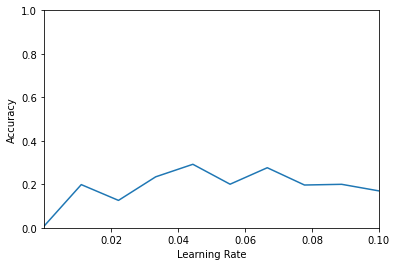

In [ ]:
#plt.plot(hypvals, averages)
# plt.xlabel('Training Cycles')
# plt.ylabel('Accuracy')

# plt.plot(cycle_sizes, cycle_avgs)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.axis([1e-5, 1e-1, 0, 1])
plt.plot(learning_rate_list, learning_rate_avg)
print(learning_rate_list)
print(learning_rate_avg)